In [82]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.metrics import  precision_score, recall_score, f1_score,balanced_accuracy_score
import seaborn as sns
from tqdm import tqdm
from utils.Preprocessing_utils import output_selection_prepro
from utils.heatmap_plots import plot_heat_map, plot_metrics
from predict_model import test_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from models.FeedForwardNet.model import Net as Net
from models.FeedForwardNet.model_3 import Net as Net3
from models.FeedForwardNet.model_2 import Net as Net2
from torchvision import models
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau
from utils.EarlyStopping import EarlyStopping
from imblearn.combine import SMOTEENN
import pytorch_warmup as warmup
import matplotlib.pyplot as plt
from IPython.display import Image
from tab_transformer_pytorch import TabTransformer

In [83]:
df = pd.read_csv('data/raw/dukecathr.csv')
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

In [84]:

train_losses=[]
train_accu=[]
eval_losses=[]
eval_accu=[]
balance_accuracy_list = []
precision_list = []
recall_list = []

In [85]:
def train_epoch(model, dataloader, criterion, optimizer, lr_scheduler, warmup_scheduler):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for data in tqdm(dataloader):
        inputs_num, inputs_cat, labels = data[0].to(device), data[1].to(device), data[2].to(device)
        optimizer.zero_grad()
        pred = model(inputs_cat, inputs_num)  # note the order of inputs
        predicted = torch.round(pred)  # Round the output probabilities to get binary predictions
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        with warmup_scheduler.dampening():
              lr_scheduler.step()
        running_loss += loss.item()
    train_loss=running_loss/len(dataloader)
    accu=100.*correct/total
    return train_loss, accu

In [86]:
def evaluate_epoch(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    for data in dataloader:
        inputs_num, inputs_cat, labels = data[0].to(device), data[1].to(device), data[2].to(device)
        outputs = model(inputs_cat, inputs_num)  # note the order of inputs
        predicted = torch.round(outputs)  # Round the output probabilities to get binary predictions
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Store all labels and predictions for metric calculation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.detach().cpu().numpy())  # Detach the tensor before converting to numpy
            
    test_loss=running_loss/len(dataloader)
    test_accu=100.*correct/total

    # Calculate metrics
    balance_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    return test_loss, test_accu, balance_acc, precision, recall

In [87]:
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=25,target ='RCAST'):
    model_path=F'models/FeedForwardNet/saved_models/{target}/best_model.pth'
    model = model.to(device)
    all_learning_rates = []
    num_steps = len(train_dataloader) * num_epochs
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)
    #lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0= 10, T_mult=2)
    #lr_scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau (optimizer,factor=0.3, patience=5)
    warmup_scheduler = warmup.RAdamWarmup(optimizer) #https://arxiv.org/pdf/1910.04209.pdf
    early_stopping = EarlyStopping(patience=30, verbose=True, model_path=model_path, delta=0.0001)

    for epoch in range(num_epochs):
        print(f'Epoch : {epoch+1}')
        train_loss, accu = train_epoch(model, train_dataloader, criterion, optimizer, lr_scheduler,warmup_scheduler)
        train_accu.append(accu)
        train_losses.append(train_loss)
        test_loss, test_accu, balance_acc, precision, recall = evaluate_epoch(model, test_dataloader, criterion)
        eval_losses.append(test_loss)
        eval_accu.append(test_accu)
        balance_accuracy_list.append(balance_acc)
        precision_list.append(precision)
        recall_list.append(recall)
        print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {accu:.3f} | Test Loss: {test_loss:.3f} | Test Accuracy: {test_accu:.3f} | Balance Accuracy: {balance_acc:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f}')
        all_learning_rates.append(optimizer.param_groups[0]["lr"])
        print(f'Learning rate: {optimizer.param_groups[0]["lr"]}')
        #lr_scheduler.step()
   
            
         # Print the current learning rate
        # early_stopping(test_loss, model)
        # if early_stopping.early_stop:
        #     print("Early stopping")
        #     break
        # Save the model if the balanced accuracy is higher than the current best
        # if balance_acc > best_bal_acc:
        #     print(f'Balanced accuracy increased ({best_bal_acc:.6f} --> {balance_acc:.6f}).  Saving model ...')
        #     os.makedirs(os.path.dirname(model_path), exist_ok=True)
        #     torch.save(model.state_dict(), model_path)  # Save the model
        #     best_bal_acc = balance_acc  # Update the best balanced accuracy
    plt.plot(all_learning_rates)
    plt.show()
        

In [88]:
import torch.nn.functional as F


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha #The alpha parameter is a weighting factor for the rare class in the case of class imbalance.
        self.gamma = gamma #The gamma parameter is a focusing parameter that reduces the relative loss for well-classified examples and puts more focus on hard, misclassified examples.
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [89]:
def evaluate_model(model, dataloader, criterion):
    model = model.to(device)  # Move the model to the GPU
    model.eval()  # Set model to evaluate mode
    running_loss=0
    correct=0
    total=0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for data in tqdm(dataloader):
            images,labels=data[0].to(device),data[1].to(device)
            outputs=model(images)
            loss= criterion(outputs,labels)
            running_loss+=loss.item()
            predicted = torch.round(outputs)  # Round the output probabilities to get binary predictions
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Store all labels and predictions for metric calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            
    test_loss=running_loss/len(dataloader)
    accu=100.*correct/total
    eval_losses.append(test_loss)
    eval_accu.append(accu)
    
    # Calculate metrics
    balance_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    # Append the metrics to the lists
    balance_accuracy_list.append(balance_acc)
    precision_list.append(precision)
    recall_list.append(recall)

    print(f'Test Loss: {test_loss:.3f} | Accuracy: {accu:.3f}')

In [90]:
def process_target(df, target, model):
    # Step 1: Preprocess the data
    X, y, num_cols, cat_cols = output_selection_prepro(df, target)
    original_columns = df.columns.tolist()
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    # get how much 0 and 1 in y_train 
    unique, counts = np.unique(y_train, return_counts=True)
    print(dict(zip(unique, counts)))
    
    Scaler = StandardScaler()
    X_train = Scaler.fit_transform(X_train)
    X_test = Scaler.transform(X_test)
    num_cols = [X.columns.get_loc(col) for col in num_cols]
    cat_cols = [X.columns.get_loc(col) for col in cat_cols]
    
    # Convert features and labels to tensors
    X_train_tensor = torch.tensor(X_train[:, num_cols].astype(np.float32))  # numerical columns
    X_train_cat_tensor = torch.tensor(X_train[:, cat_cols].astype(np.int64))  # categorical columns
    X_test_tensor = torch.tensor(X_test[:, num_cols].astype(np.float32))  # numerical columns
    X_test_cat_tensor = torch.tensor(X_test[:, cat_cols].astype(np.int64))  # categorical columns
    y_train_tensor = torch.tensor(y_train.values).float().unsqueeze(1)
    y_test_tensor = torch.tensor(y_test.values).float().unsqueeze(1)

    # Convert the data into PyTorch tensors and load them into a DataLoader
    train_data = TensorDataset(X_train_tensor, X_train_cat_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, X_test_cat_tensor, y_test_tensor)
    #save test data
    torch.save(test_data, f'data/processed/{target}/test_data.pth')

    batch_size = 512
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
    
    cat_cols_names = [original_columns[i] for i in cat_cols]
    categories = tuple(df[cat_cols_names].nunique())

   # Define the model, loss function, and optimizer
    model = TabTransformer(
      categories = categories, # number of unique categories in each column
      num_continuous = len(num_cols), # number of continuous features
      dim = 32, # dimension
      dim_out = 1, # binary classification
      depth = 6, # depth
      heads = 8, # number of attention heads
      attn_dropout = 0.1, # post-attention dropout
      ff_dropout = 0.1, # feed-forward dropout
      mlp_hidden_mults = (4, 2), # relative multiples of each hidden dimension of the last mlp to logits
      mlp_act = nn.ReLU(), # activation for final mlp
  )
    criterion = nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(),lr=0.00023675, betas=(0.9, 0.9985))
    #https://arxiv.org/pdf/1910.04209.pdf
    #rcast lr=0.00023675, betas=(0.9, 0.9985)
    # Train the model
    criterion = nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(),lr=0.00023675, betas=(0.9, 0.9985))

    # Train the model
    num_epochs = 150
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs_num, inputs_cat, labels = data[0].to(device), data[1].to(device), data[2].to(device)
            optimizer.zero_grad()  # Zero the parameter gradients
            pred = model(inputs_cat, inputs_num)  # note the order of inputs
            loss = criterion(pred, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize
            running_loss += loss.item()
        print(f"Epoch {epoch+1} loss: {running_loss/len(train_loader)}")

    # Evaluate the model
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    with torch.no_grad():  # No need to track gradients in evaluation mode
        for i, data in enumerate(test_loader, 0):
            inputs_num, inputs_cat, labels = data[0].to(device), data[1].to(device), data[2].to(device)
            pred = model(inputs_cat, inputs_num)  # note the order of inputs
            loss = criterion(pred, labels)  # Compute loss
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()
    print(f"Test loss: {running_loss/len(test_loader)}")
    print(f"Test accuracy: {correct_predictions/len(test_loader.dataset)}")

In [91]:
process_target(df, 'RCAST', Net3(43))

Loading data from data/processed/RCAST/imputed_data_RCAST.csv...
No missing values found.
Final X columns: ['RDAYSFROMINDEX', 'RSEQCATHNUM', 'RSUBJID', 'YRCATH_G', 'AGE_G', 'GENDER', 'RACE_G', 'DPCABG', 'DPMI', 'DPPCI', 'HXANGINA', 'HXCEREB', 'HXCHF', 'HXCOPD', 'HXDIAB', 'HXHTN', 'HXHYL', 'HXMI', 'HXSMOKE', 'NUMPRMI', 'DIASBP_R', 'PULSE_R', 'SYSBP_R', 'CBRUITS', 'HEIGHT_R', 'S3', 'WEIGHT_R', 'CREATININE_R', 'HDL_R', 'LDL_R', 'TOTCHOL_R', 'CATHAPPR', 'DIAGCATH', 'INTVCATH', 'CORDOM', 'GRAFTST', 'LVEF_R', 'DAYS2LKA', 'DSCABG', 'DSMI', 'DSPCI', 'DSSTROKE', 'FUPROTCL']


RuntimeError: one_hot is only applicable to index tensor.

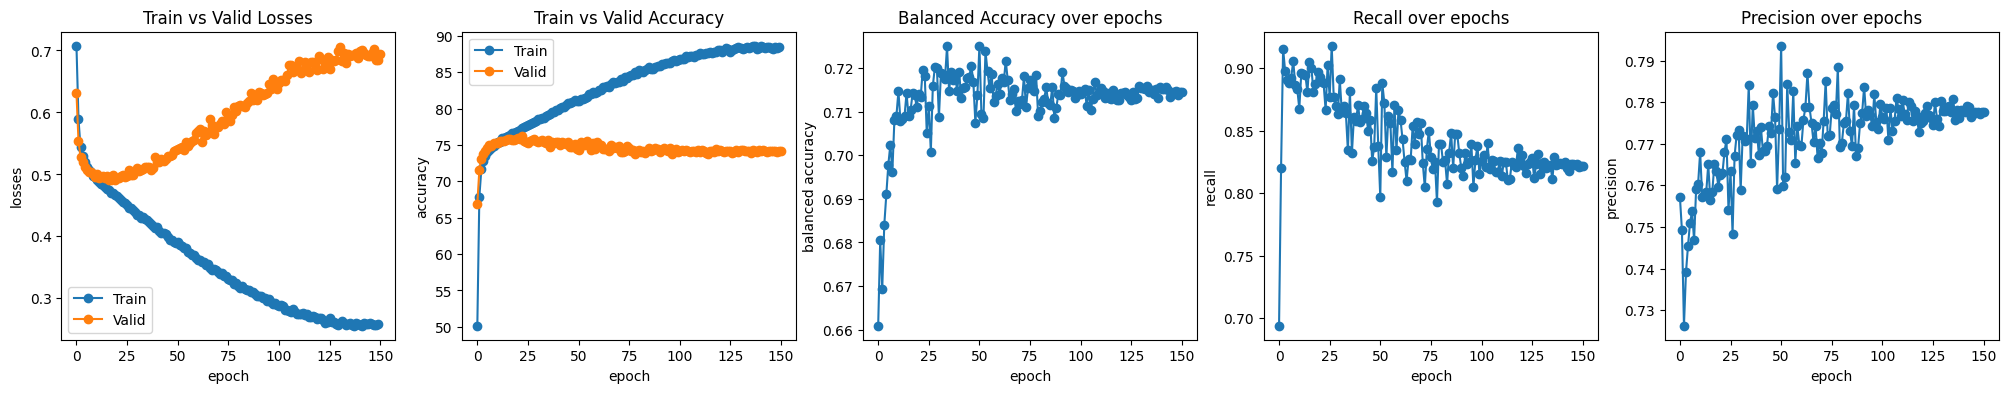

In [ ]:
# plot the loss and accuracy and
metrics = {
    'train_losses': train_losses,
    'train_accu': train_accu,
    'eval_losses': eval_losses,
    'eval_accu': eval_accu,
    'balance_accuracy_list': balance_accuracy_list,
    'precision_list': precision_list,
    'recall_list': recall_list
}
plot_metrics(metrics, ['loss', 'accuracy', 'balance_accuracy', 'recall', 'precision'])

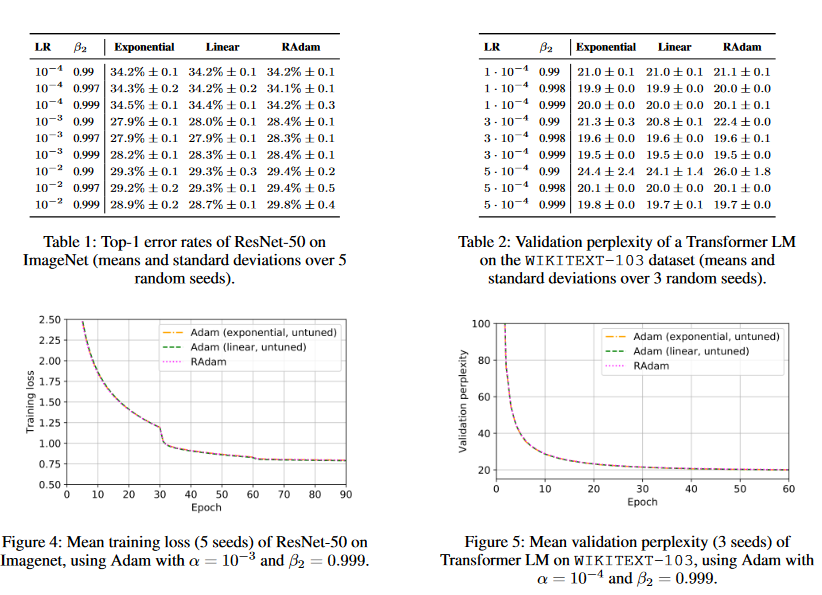

In [ ]:

#adaptive learning rate can have high variance in the early stages of training
Image(filename='data\Screenshot 2023-11-01 234812.png')

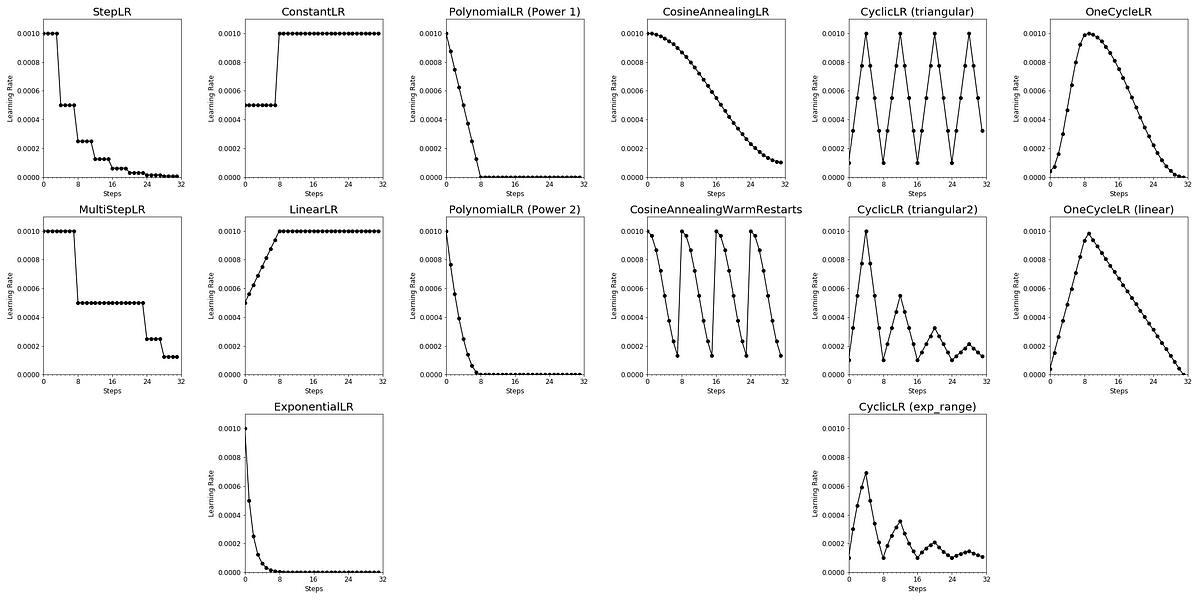

In [ ]:
Image(filename='data\qe6nYlH8zsmUdScyHMhRCQ-3509617497.png')

In [ ]:
accuracy, precision, recall, balance_accuracy = test_model('RCAST')

In [ ]:
print('Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | Balance Accuracy: {balance_accuracy:.3f}')

Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | Balance Accuracy: {balance_accuracy:.3f}
